In [79]:
import pandas as pd
import numpy as np
import os
import csv
import cv2
import math
import matplotlib.pyplot as plt
import keras

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from keras.models import Sequential
from keras.layers import (Input, Conv2D, Activation, 
                          ZeroPadding2D, MaxPooling2D, Flatten, 
                          Dense, Lambda, Dropout, Concatenate)
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tqdm.keras import TqdmCallback

# config to run on GPU
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

IMG_HEIGHT= 112
IMG_WIDTH = 224
BATCH_SIZE = 16
DATA_DIR = 'data'

np.random.seed(0)

1 Physical GPUs, 1 Logical GPUs


## Load the data

In [80]:
df = pd.read_csv(os.path.join(DATA_DIR, 'video_data.csv'))
df.head()

,frame,image_path,speed
0,0,data/training_images/0.jpg,28.105569
1,1,data/training_images/1.jpg,28.105569
2,2,data/training_images/2.jpg,28.106527
3,3,data/training_images/3.jpg,28.130404
4,4,data/training_images/4.jpg,28.109243


In [81]:
# Rename image column and put both frames on one row
df.rename(columns={'image_path': 'image_1'}, inplace=True)
df['image_2'] = df['image_1'].shift(periods=-1)

# Change speed to mean speed between two frames
df ['speed'] = df['speed'].rolling(2).mean()
df.dropna(inplace=True)
df.head()

,frame,image_1,speed,image_2
1,1,data/training_images/1.jpg,28.105569,data/training_images/2.jpg
2,2,data/training_images/2.jpg,28.106048,data/training_images/3.jpg
3,3,data/training_images/3.jpg,28.118465,data/training_images/4.jpg
4,4,data/training_images/4.jpg,28.119823,data/training_images/5.jpg
5,5,data/training_images/5.jpg,28.098907,data/training_images/6.jpg


In [82]:
# Split the data into training and validation
train_data, valid_data = train_test_split(df, test_size=0.25,
                                          random_state=0)

### Image preprocessing

I tried many different techniques for image preprocessing. I found that resizing the images to elongate the width seemed to help with accuracy. I also increased the brightness and saturation as the original images were a bit dark.

Some random augmentation is applied to the training images to help prevent the model from over-fitting. Half of the images are flipped horizontally and the brightness and saturation are applied stochastically. 

In [138]:
def get_image_augment(image_path, saturation, brightness, h_flip):
    """
    Function to load images for training generator.

    Args:
        image_path (string): The path to the image to be loaded
        saturation (float): Parameter to control additional saturation
        brightness (float): Parameter to control additional brightness
        hflip (float): If more than 0.5 then flips image horizontally
    Returns:
        Scaled, cropped and augmented image
    """
    image = cv2.imread(image_path)
    # Convert image to HSV 
    hsvImg = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    
    # Apply saturation/brightness using random params
    hsvImg[...,1] = hsvImg[...,1] * (1.0 + (0.8 * saturation))
    hsvImg[...,2] = hsvImg[...,2] * (1.0 + (0.5 * brightness))
    # Convert back to BGR
    image = cv2.cvtColor(hsvImg,cv2.COLOR_HSV2BGR)
    # Crop image to remove interior of car
    image = image[150:400, :]
    # Flip 50% of images horizontally
    if h_flip > 0.5:
        image = np.fliplr(image)
    # Resize image
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT),
                       interpolation=cv2.INTER_AREA)
    # Return scaled image
    return image / 255.0


In [139]:
def get_image(image_path):
    """
    Function to load images for validation generator 
    """
    image = cv2.imread(image_path)
    # Convert image to HSV
    hsvImg = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    
    # Increase saturation and brightness
    hsvImg[...,1] = hsvImg[...,1] * 1.4
    hsvImg[...,2] = hsvImg[...,2] * 1.25
    # Convert back to BGR
    image = cv2.cvtColor(hsvImg,cv2.COLOR_HSV2BGR)
    # Crop image to remove interior of car
    image = image[150:400, :]

    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT),
                       interpolation=cv2.INTER_AREA)
    return image /255.0

Original image:


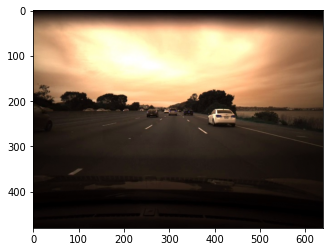

Version 1
Saturation: 0.05, Brightness: 0.65


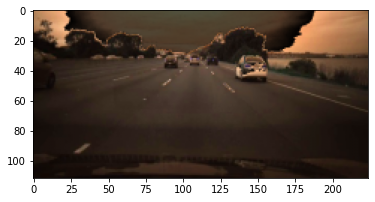

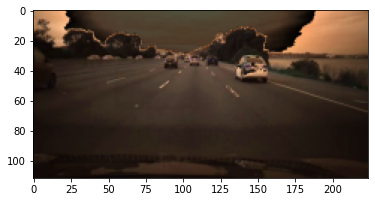

Version 2
Saturation: 0.83, Brightness: 0.33


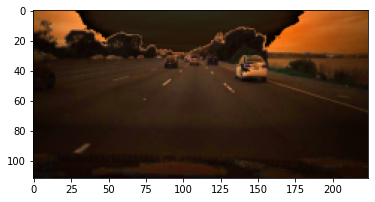

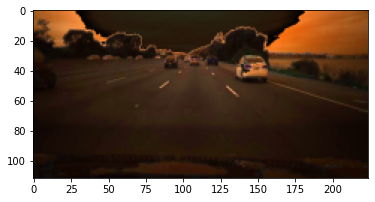

Version 3
Saturation: 0.47, Brightness: 0.89


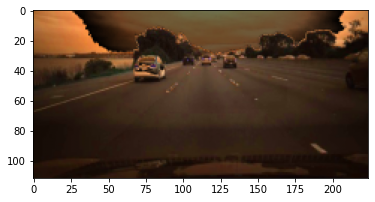

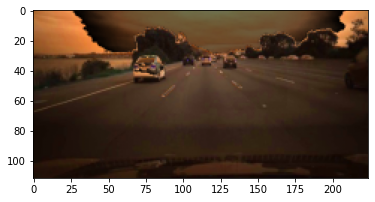

In [150]:
# Get a sample row to check image augmentation
sample = train_data.sample()

print('Original image:')

image1 = cv2.imread(sample['image_1'].values[0])
image1 = image1 / 255.0
plt.imshow(image1)
plt.show()

for i in range(3):
    saturation, brightness, h_flip = np.random.sample(3)
    
    img1 = get_image_augment(sample['image_1'].values[0], saturation, brightness, h_flip)
    img2 = get_image_augment(sample['image_2'].values[0], saturation, brightness, h_flip)
    
    print(f'Version {i+1}')
    print(f'Saturation: {saturation:.2f}, Brightness: {brightness:.2f}')
    plt.imshow(img1)
    plt.show()
    plt.imshow(img2)
    plt.show()


As seen from the images above, the additional brightness and saturation help to make the images appear sharper and have brought out details which were in the dark before. They also provide some random augmentations that should help avoiding overfitting by getting the most out of the data we have.

## Create the generator

The generator will create batches for training and testing the model. Image augmentation can be disabled by setting validation_mode to true.

In [141]:
class DataGenerator(keras.utils.Sequence):
    """
    Custom generator to create batches of images.
    Batches are shuffled unless validation_mode
    is set to True.
    
    Args:
        data_frame (Pandas DataFrame): Rows are pairs of images
        dims (tuple): Image height and width
        n_channels (int): Number of channels for images
        batch_size (int): Batch size for model
        validation_mode (bool): If set to True then samples are not 
                                shuffled and augmentation applied
                                consistently instead of stochastically
        test_mode (bool): If set to True then batches are returned 
                          without labels
    """
    def __init__(self, data_frame,
                 dims=(IMG_HEIGHT, IMG_WIDTH),
                 n_channels = 3,
                 batch_size = BATCH_SIZE,
                 validation_mode = False,
                 test_mode = False):
        self.data_frame = data_frame
        self.dims = dims
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.validation_mode = validation_mode
        self.test_mode = test_mode
        self.indices = np.arange(len(self.data_frame))

        self.on_epoch_end()
        
    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(len(self.data_frame) / self.batch_size))
    
    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        # Generate indices of the batch
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # find list of samples
        sample_list = [self.data_frame.iloc[i] for i in indices]
        
        # Generate data
        X, y = self.__data_generation(sample_list)
        
        return X, y
    
    def __data_generation(self, sample_list):
        """
        Generates data containing batch_size samples
        """
        X1 = np.empty((self.batch_size, *self.dims, self.n_channels))
        X2 = np.empty((self.batch_size, *self.dims, self.n_channels))
        labels = np.empty((self.batch_size))
        
        for i in range(len(sample_list)):
            img_path1 = sample_list[i]['image_1']
            img_path2 = sample_list[i]['image_2']
            
            if not self.validation_mode:            
                # get random variables to augment image
                saturation, brightness, h_flip = np.random.sample(3)

                img1 = get_image_augment(img_path1, saturation, brightness, h_flip)
                img2 = get_image_augment(img_path2, saturation, brightness, h_flip)
            else:
                img1 = get_image(img_path1)
                img2 = get_image(img_path2)
            
            X1[i] = img1
            X2[i] = img2
            
            if not self.test_mode:
                labels[i] = sample_list[i]['speed']
        
        return ([X1, X2], labels)
            
    def on_epoch_end(self):
        if not self.validation_mode:
            np.random.shuffle(self.indices)

In [142]:
training_gen = DataGenerator(train_data)
validation_gen = DataGenerator(valid_data, validation_mode=True)

### Build the model

The model takes two images as input and concatenates them. The architecture is roughly based on the paper linked below. 

http://cs229.stanford.edu/proj2017/final-reports/5244226.pdf

In [143]:
def create_model(activation='relu'):
    input1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    input2 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    merged = Concatenate()([input1, input2])
    
    x = Conv2D(64, kernel_size=(3, 3),
                activation=activation,
                strides=(2,2))(merged)
    x = Conv2D(64, kernel_size=(3, 3),
                activation=activation,
                strides=(2,2))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3),
                activation=activation,
                strides=(2,2))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(4096, activation=activation)(x)
    x = Dense(2048, activation=activation)(x)
    x = Dense(1024, activation=activation)(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=[input1, input2], outputs=output)

    return model
    

In [ ]:
model = create_model()
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')

# model.summary()

In [145]:
callbacks = [
    EarlyStopping(restore_best_weights=True, monitor='val_loss', patience=1),
    ModelCheckpoint('best_model.hdf5', monitor='val_loss',
                    save_best_only=True, verbose=1),
]

history = model.fit_generator(generator=training_gen,
                              validation_data=validation_gen,
                              epochs=10,
                              callbacks=callbacks,
                              verbose=1
                             )

Epoch 1/10
956/956 [==============================] - 329s 344ms/step - loss: 18.3517 - val_loss: 2.4516

Epoch 00001: val_loss improved from inf to 2.45160, saving model to best_model.hdf5
Epoch 2/10
956/956 [==============================] - 316s 330ms/step - loss: 4.1899 - val_loss: 1.4869

Epoch 00002: val_loss improved from 2.45160 to 1.48691, saving model to best_model.hdf5
Epoch 3/10
956/956 [==============================] - 320s 335ms/step - loss: 2.7764 - val_loss: 0.8082

Epoch 00003: val_loss improved from 1.48691 to 0.80821, saving model to best_model.hdf5
Epoch 4/10
956/956 [==============================] - 320s 335ms/step - loss: 1.9261 - val_loss: 1.1233

Epoch 00004: val_loss did not improve from 0.80821


### Get predictions

We will save both our training and test predicitons and use these to evaluate performance. We can also look at improving predictions by trying to smooth out any outliers. 

In [92]:
# model = keras.models.load_model('best_model.hdf5')

In [147]:
# Get training predictions
all_train_gen = DataGenerator(df, validation_mode=True)
train_preds = model.predict_generator(all_train_gen)
np.save(os.path.join(DATA_DIR, 'train_preds.npy'), train_preds)

In [148]:
# Create test dataframe
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test_data.csv'))

# Rename image column and put both frames on one row
test_df.rename(columns={'image_path': 'image_1'}, inplace=True)
test_df['image_2'] = test_df['image_1'].shift(periods=-1)
test_df.dropna(inplace=True)

test_df.head()

,frame,image_1,image_2
0,0,data/test_images/0.jpg,data/test_images/1.jpg
1,1,data/test_images/1.jpg,data/test_images/2.jpg
2,2,data/test_images/2.jpg,data/test_images/3.jpg
3,3,data/test_images/3.jpg,data/test_images/4.jpg
4,4,data/test_images/4.jpg,data/test_images/5.jpg


In [149]:
# Get test predictions
test_gen = DataGenerator(test_df, validation_mode=True, test_mode=True)
test_preds = model.predict_generator(test_gen)
np.save(os.path.join(DATA_DIR, 'test_preds.npy'), test_preds)